### Semi-superivsed learning

Integrantes:
- Miguel Brito
- Diana Cuenca
- Steveen Terán
- Danny Huacon
- José I. Escudero

P2_Project_IA202410_MB1DC2ST3DH4JE5

#### 1. Definición de librerías y funciones

In [17]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from typing import Literal

MNIST_URL = 'https://raw.githubusercontent.com/sbussmann/kaggle-mnist/fd6de8baf8995ff26f441cd51c302f77bc7ec8c7/Data/train.csv'
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED) # set seed for reproducibility

# Fetch MNIST data from GitHub
def fetch_data() -> pd.DataFrame:
  return pd.read_csv(MNIST_URL)

# Obtain n samples using the specified method
def select_balanced_samples(df: pd.DataFrame, n: int, method: Literal['random', 'kmeans']) -> pd.DataFrame:
    samples_per_class = n // 10
    if method == 'random':
        return df.groupby('label', group_keys=False).apply(lambda x: x.sample(samples_per_class))
    elif method == 'kmeans':
        indices = []
        for label in range(10):
            cluster_data = df[df['label'] == label]
            kmeans = KMeans(n_clusters=samples_per_class, random_state=RANDOM_SEED, n_init=10)
            kmeans.fit(cluster_data.drop('label', axis=1))
            centroids = kmeans.cluster_centers_
            closest, _ = pairwise_distances_argmin_min(centroids, cluster_data.drop('label', axis=1))
            indices.extend(cluster_data.iloc[closest].index)
        return df.loc[indices]
    else:
        raise ValueError("Unknown method.")

# Train the specified model and return the accuracy score on the test set
def train_and_evaluate(model: MLPClassifier | DecisionTreeClassifier, X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series) -> float:
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return accuracy_score(y_test, predictions)

# Plot the specified images
def plot_digits(images: np.ndarray, title: str, images_per_row=10) -> None:
    plt.figure(figsize=(20, 2))
    for index, image in enumerate(images):
        plt.subplot(1, images_per_row, index + 1)
        plt.imshow(image.reshape(28, 28), cmap='binary')
        plt.axis('off')
    plt.suptitle(title)
    plt.grid(True)
    plt.show()

#### 2. Obtener datos y separar en datos de entrenamiento y prueba

In [18]:
mnist = fetch_data()

 # Split data into training and testing sets
features = mnist.drop('label', axis=1)
labels = mnist['label']
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=RANDOM_SEED)

#### 3. Definir modelos de clasificación

In [19]:
 # Initialize models
mlp = MLPClassifier(random_state=RANDOM_SEED)
tree = DecisionTreeClassifier(random_state=RANDOM_SEED)

# Test different sample sizes
sample_sizes = [10, 50, 100, 300]
results = {'mlp_random': [], 'mlp_kmeans': [], 'tree_random': [], 'tree_kmeans': []}

#### 4. Entrenar modelos de clasificación

In [20]:
for size in sample_sizes:
    size = max(size, 10 * (size // 10))
    samples_random = select_balanced_samples(mnist, size, 'random')
    samples_kmeans = select_balanced_samples(mnist, size, 'kmeans')

    X_train_random, y_train_random = samples_random.drop('label', axis=1), samples_random['label']
    X_train_kmeans, y_train_kmeans = samples_kmeans.drop('label', axis=1), samples_kmeans['label']

    results['mlp_random'].append(train_and_evaluate(mlp, X_train_random, y_train_random, X_test, y_test))
    results['mlp_kmeans'].append(train_and_evaluate(mlp, X_train_kmeans, y_train_kmeans, X_test, y_test))
    results['tree_random'].append(train_and_evaluate(tree, X_train_random, y_train_random, X_test, y_test))
    results['tree_kmeans'].append(train_and_evaluate(tree, X_train_kmeans, y_train_kmeans, X_test, y_test))

#### 5. Graficar resultados

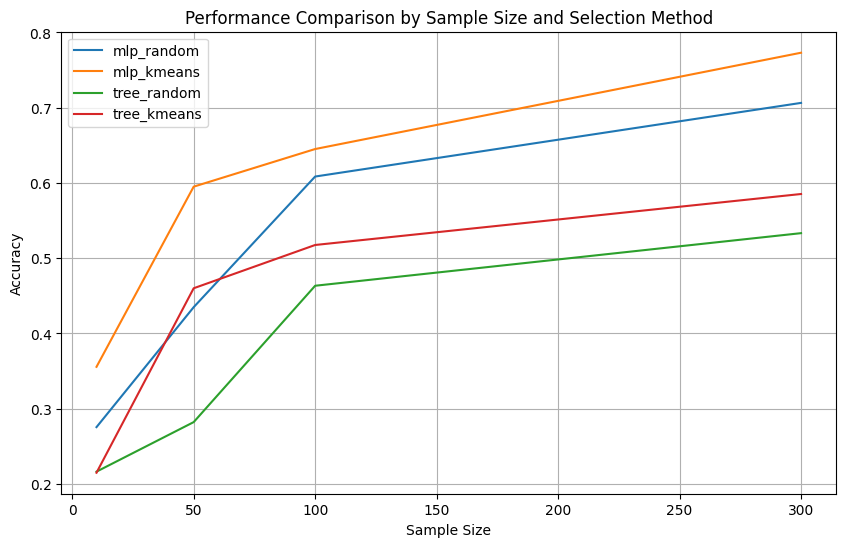

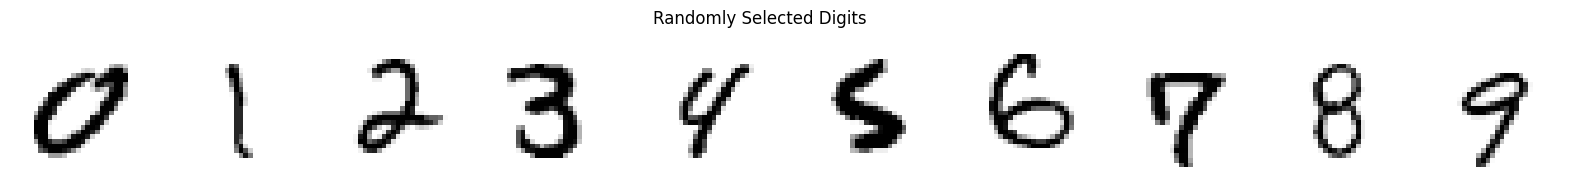

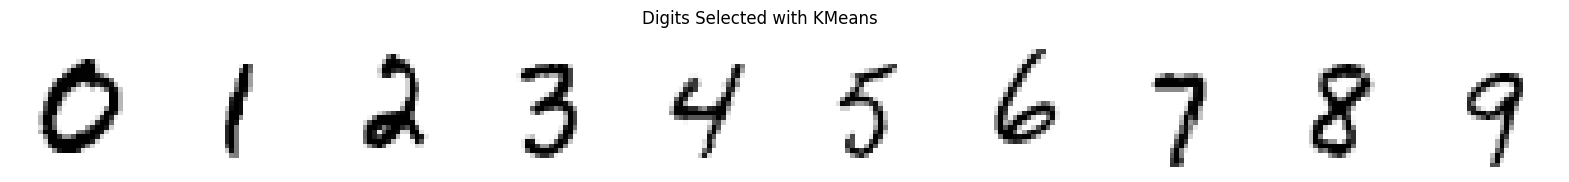

In [21]:
# Plot results
plt.figure(figsize=(10, 6))
for key, value in results.items():
    plt.plot(sample_sizes, value, label=key)
plt.xlabel('Sample Size')
plt.ylabel('Accuracy')
plt.title('Performance Comparison by Sample Size and Selection Method')
plt.legend()
plt.grid(True)
plt.show()

# Plot selected digits
n_digits = 10
digits_random = select_balanced_samples(mnist, n_digits, 'random').drop('label', axis=1).values
plot_digits(digits_random, title='Randomly Selected Digits')

digits_kmeans = select_balanced_samples(mnist, n_digits, 'kmeans').drop('label', axis=1).values
plot_digits(digits_kmeans, title='Digits Selected with KMeans')

